# Cobalt Heat Map (working copy)
by Eric Meunier

The task is to create a heat map of the likelyhood of finding cobalt. Cobalt is most likely to occur where serpentinite and granodiorite are in contact (or close proximity). For the purposes of this exercise, all ultramafic rocks will is assumed to also be serpentinite.

This will be accomplished by creating a grid of coordinates over the zone of interest, and calculating the distance to the nearest granodiorite and serpentinite unit. The mean distance between the two will be used as the distance value for this coordinate. This mesh will then be used to create a contour map.

Distance to a geological unit will be calculated by measuring from each coordinate that defines the exterior of the polygon and using the minima.

Since there are many calculations to be made, we will use vectorized numpy functions wherever possible to save on computation time.

We will use geopandas to view and manipulate the data from the shapefiles, and matplotlib for plotting.

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
pd.set_option('display.max_columns', None)  # Display all the columns when looking at the data frames

shp_file = r"Sample_files/BedrockP.shp"
shp_df = gpd.read_file(shp_file)
display(shp_df)

,gid,upid,area_m2,strat_unit,era,period,strat_age,strat_name,gp_suite,fm_lithodm,mem_phase,rock_class,rock_type,rk_char,unit_desc,age_max,age_min,belt,terrane,basin,basin_age,project,src_url,src_ref_s,map_comp,edit_date,pub_org,geometry
0,33649.0,9c192ffb,4368828.0,uKPCvl,Mesozoic,Cretaceous,Upper Cretaceous,Powell Creek Formation - upper unit,NaN,Powell Creek Formation,upper unit,volcanic rocks,coarse volcaniclastic and pyroclastic volcanic...,NaN,"Well stratified lapilli tuff, volcanic breccia...",Santonian,Campanian,Coast,Overlap,NaN,NaN,Chilcotin-Bonaparte,http://www.em.gov.bc.ca/Mining/Geoscience/Publ...,"Schiarizza et al., 1997, Chilcotin-Bonaparte, ...","Schiarizza, 2017, Chicotin-Bonaparte",2018-04-05,British Columbia Geological Survey,"POLYGON ((466212.803 5669781.240, 466385.735 5..."
1,26344.0,824df15e,34431394.0,lKGsv,Mesozoic,Cretaceous,Lower Cretaceous,Gambier Group,Gambier Group,NaN,NaN,sedimentary rocks,marine sedimentary and volcanic rocks,NaN,Undifferentiated Gambier Group volcanic and se...,Lower Cretaceous,Mid-Cretaceous,Coast,Overlap,NaN,NaN,Mid-coast,http://www.em.gov.bc.ca/Mining/Geoscience/Publ...,"Bellefontaine et al., 1994, Mid-coast, BCGS, O...","Massey et al., 2005, BC",2018-04-05,British Columbia Geological Survey,"POLYGON ((541326.012 5529535.059, 541118.840 5..."
2,29100.0,2f4fa4a6,74490974.0,lKGsv,Mesozoic,Cretaceous,Lower Cretaceous,Gambier Group,Gambier Group,NaN,NaN,sedimentary rocks,marine sedimentary and volcanic rocks,NaN,Undifferentiated Gambier Group volcanic and se...,Lower Cretaceous,Mid-Cretaceous,Coast,Overlap,NaN,NaN,Mid-coast,http://www.em.gov.bc.ca/Mining/Geoscience/Publ...,"Bellefontaine et al., 1994, Mid-coast, BCGS, O...","Massey et al., 2005, BC",2018-04-05,British Columbia Geological Survey,"POLYGON ((541118.840 5528958.183, 541326.012 5..."
3,18121.0,8c3e4237,28858519.0,JKCsf,Mesozoic,Jurassic to Cretaceous,Jurassic to Cretaceous,Cayoosh assemblage?,Cayoosh assemblage?,NaN,NaN,sedimentary rocks,"mudstone, siltstone, shale fine clastic sedime...",NaN,"Siltstone, argillite, slate; lesser sandstone,...",Jurassic,Cretaceous,Coast,Bridge River,NaN,NaN,Okanagan,http://www.em.gov.bc.ca/Mining/Geoscience/Publ...,"Schiarizza and Church., 1996, Okanagan, BCGS, ...","Massey et al., 2005, BC",2018-04-05,British Columbia Geological Survey,"POLYGON ((508143.471 5601807.482, 508301.595 5..."
4,18113.0,d7681ec3,38898103.0,Mivb,Cenozoic,Neogene,Miocene,NaN,NaN,NaN,NaN,volcanic rocks,basaltic volcanic rocks,NaN,Basalt flows and breccia; locally intercalated...,Miocene,Miocene,Coast,Younger Volcanics,NaN,NaN,Okanagan,http://www.em.gov.bc.ca/Mining/Geoscience/Publ...,"Schiarizza and Church., 1996, Okanagan, BCGS, ...","Massey et al., 2005, BC",2018-04-05,British Columbia Geological Survey,"POLYGON ((508835.893 5603890.448, 508674.020 5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1591,26392.0,28901258,14445054.0,MKgd,Mesozoic,Cretaceous,mid-Cretaceous,NaN,NaN,NaN,NaN,intrusive rocks,granodioritic intrusive rocks,NaN,Variably foliated granodiorite; lesser quartz ...,Mid-Cretaceous,Mid-Cretaceous,Coast,Post Accretionary,NaN,NaN,Mid-coast,http://www.em.gov.bc.ca/Mining/Geoscience/Publ...,"Bellefontaine et al., 1994, Mid-coast, BCGS, O...","Massey et al., 2005, BC",2018-04-05,British Columbia Geological Survey,"POLYGON ((476082.704 5549727.241, 475761.952 5..."
1592,31814.0,f69839c7,1269847.0,PiHoGvb,Cenozoic,Neogene to Quaternary,Pliocene to Holocene,Garibaldi Group,Garibaldi Group,NaN,NaN,volcanic rocks,basaltic volcanic rocks,NaN,Late Glacial to Early Post Glacial: olivine b...,Pliocene,Holocene,Coast,Younger Volcanics,NaN,NaN,Mid-coast,http://www.em.gov.bc.ca/Mining/Geoscience/Publ...,"Bellefontaine et al., 1994, Mid-coast, BCGS, O...","Massey et al., 2005, BC",2018-04-05,British Columbia Geological Survey,"POLYGON ((496613.988 5534771.006, 496315.971 5..."
1593,31784.0,2f792b86,818647.0,PiHoGvb,Cenozoic,Neogene to Quate

<Axes: >

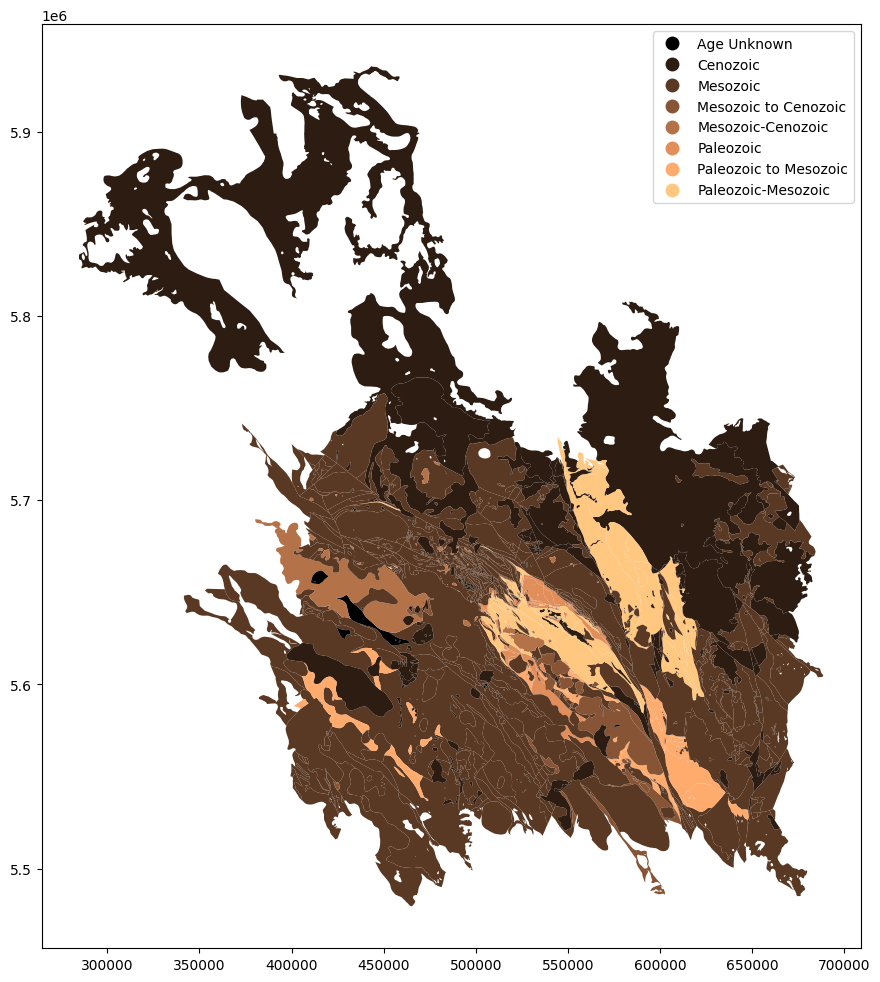

In [4]:
shp_df.plot(column="era", categorical=True, legend=True, figsize=
(12,12), cmap='copper')

Take a look at what rock classes and rock types exist.

In [5]:
shp_df["rock_class"].unique()

array(['volcanic rocks', 'sedimentary rocks', 'intrusive rocks',
       'ultramafic rocks', 'metamorphic rocks'], dtype=object)

In [6]:
shp_df["rock_type"].unique()

array(['coarse volcaniclastic and pyroclastic volcanic rocks',
       'marine sedimentary and volcanic rocks',
       'mudstone, siltstone, shale fine clastic sedimentary rocks',
       'basaltic volcanic rocks', 'undivided sedimentary rocks',
       'andesitic volcanic rocks', 'feldspar porphyritic intrusive rocks',
       'granodioritic intrusive rocks', 'ultramafic rocks',
       'quartz dioritic intrusive rocks',
       'granite, alkali feldspar granite intrusive rocks',
       'serpentinite ultramafic rocks',
       'coarse clastic sedimentary rocks', 'undivided volcanic rocks',
       'dioritic intrusive rocks',
       'greenstone, greenschist metamorphic rocks',
       'orthogneiss metamorphic rocks',
       'argillite, greywacke, wacke, conglomerate turbidites',
       'quartz monzonitic intrusive rocks',
       'calc-alkaline volcanic rocks',
       'mid amphibolite/andalusite grade metamorphic rocks',
       'rhyolite, felsic volcanic rocks',
       'conglomerate, coarse clas

In [7]:
ultramafic_filt = shp_df["rock_class"].str.contains("ultramafic rocks")
ultramafic_matches = shp_df[ultramafic_filt]
print(f"Number of matches: {len(ultramafic_matches)}")
print(f"Rock type(s): {ultramafic_matches['rock_type'].unique()}")

Number of matches: 46
Rock type(s): ['ultramafic rocks']


All ultramafic rocks will be assumed to be serpentinite

In [8]:
granodiorite_filt = shp_df["rock_type"].str.contains("grano")
granodiorite_matches = shp_df[granodiorite_filt]
print(f"Matches: {granodiorite_matches['rock_type'].unique()}")
print(f"Number of matches: {len(granodiorite_matches)}")
print(f"Classification(s): {granodiorite_matches['rock_class'].unique()}")

Matches: ['granodioritic intrusive rocks']
Number of matches: 147
Classification(s): ['intrusive rocks']


Looks like granodiorites only exist as 'granodioritic intrusive rocks'

In [9]:
serpentinite_filt = shp_df["rock_type"].str.contains("serp")
serpentinite_matches = shp_df[serpentinite_filt]
print(f"Matches: {serpentinite_matches['rock_type'].unique()}")
print(f"Number of matches: {len(serpentinite_matches)}")
print(f"Classification(s): {serpentinite_matches['rock_class'].unique()}")

Matches: ['serpentinite ultramafic rocks']
Number of matches: 42
Classification(s): ['metamorphic rocks']


Serpentinite is entered as 'serpentinite ultramafic rocks'.

Add the ultramafic rocks to the dataset of serpentinite rocks

In [10]:
serpentinite_filt = shp_df["rock_type"].str.contains("serp") | shp_df["rock_class"].str.contains("ultramafic rocks")
serpentinite_matches = shp_df[serpentinite_filt]
print(f"Matches: {serpentinite_matches['rock_type'].unique()}")
print(f"Number of matches: {len(serpentinite_matches)}")
print(f"Classification(s): {serpentinite_matches['rock_class'].unique()}")

Matches: ['ultramafic rocks' 'serpentinite ultramafic rocks']
Number of matches: 88
Classification(s): ['ultramafic rocks' 'metamorphic rocks']


<Axes: >

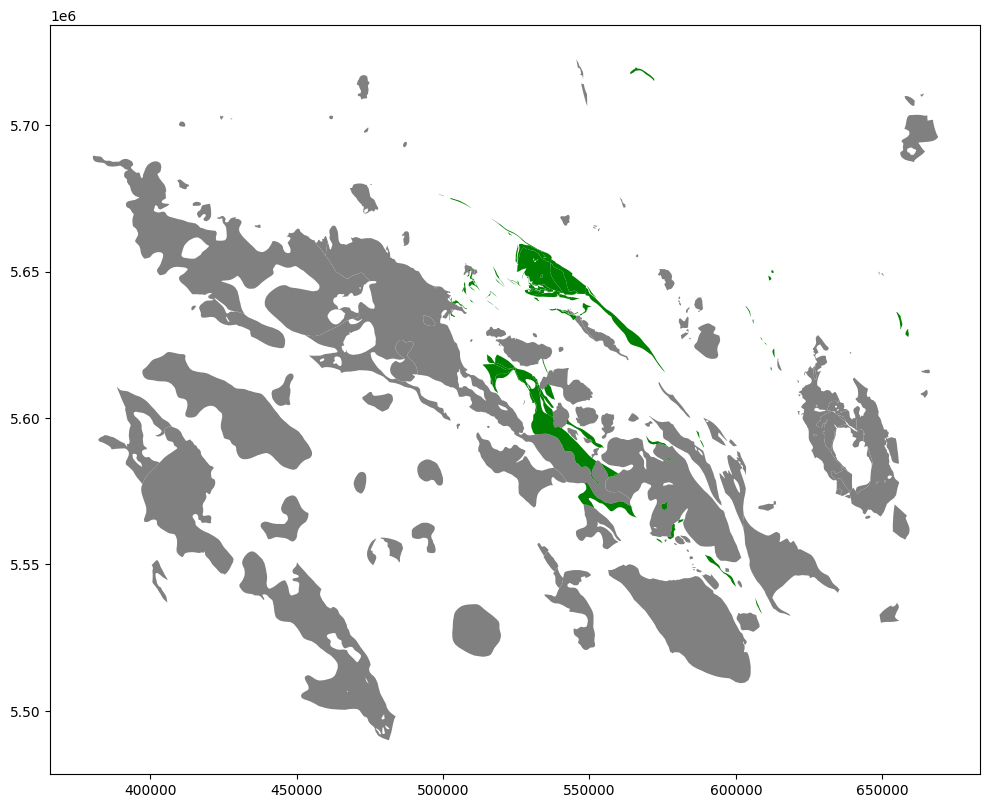

In [11]:
fig, ax = plt.subplots(figsize=(12, 12))
granodiorite_matches.plot(ax=ax, color="gray", zorder=1, label="Granodiorite")
serpentinite_matches.plot(ax=ax, color="green", zorder=2, label="Serpentinite")

Looking at this map, we expect the probability to be high near the center of the map where a lot of serpentinite and granodiorite are in contact.

Create a grid of coodinates from which distances will be calculated.

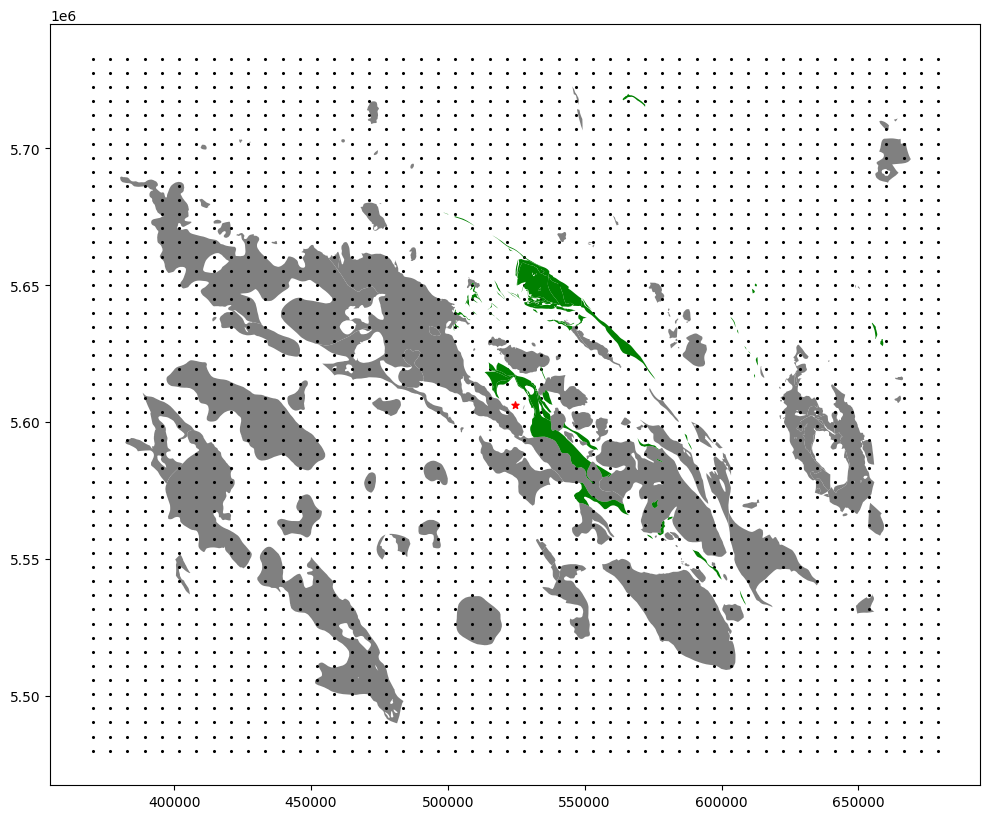

In [24]:
zone_of_interest = shp_df[granodiorite_filt | serpentinite_filt]  # Only calculate distances that are within the zone of interest to reduce computation time.
falloff_distance = 10000  # meters
# Apply a buffer to the zone of interest to ensure our measurements go at least to the fall off distance.
xmin, ymin, xmax, ymax = zone_of_interest.buffer(falloff_distance).total_bounds

# Calculate the center for testing purposes
center_x, center_y = ((xmax - xmin) / 2) + xmin, ((ymax - ymin) / 2) + ymin 

# grid_spacing = 5000  # meters
# xi = np.arange(xmin, xmax + grid_spacing, grid_spacing)  # Add grid_spacing to the maximum value because np.arange excludes the upper limit
# yi = np.arange(ymin, ymax + grid_spacing, grid_spacing)
num_divisions = 50
xi = np.linspace(xmin, xmax, num_divisions)  # Divide the zone of interest into 50 equal segments.
yi = np.linspace(ymin, ymax, num_divisions)
xx, yy = np.meshgrid(xi, yi)

fig, ax = plt.subplots(figsize=(12, 12))
granodiorite_matches.plot(ax=ax, color="gray", zorder=1)
serpentinite_matches.plot(ax=ax, color="green", zorder=2)
ax.scatter(xx, yy, 6, marker='.', color='k')
ax.scatter([center_x], [center_y], 28, marker='*', color='r')

In [25]:
# # %%timeit
# # Not as fast the calc_distance
# def calc_distance_hypot(target_x, target_y, xx, yy):
#     return np.hypot(xx - target_x, yy - target_y)

# zz = calc_distance_hypot(center_x, center_y, xx, yy)

In [26]:
%%timeit
def calc_distance(target_x: float, target_y: float, xx: np.array, yy: np.array) -> np.array:
    'Calculate the euclidean distance between a target coordinate and each coordinate in the xx, yy grid mesh'
    return np.sqrt((xx - target_x)**2 + (yy - target_y)**2)

zz = calc_distance(center_x, center_y, xx, yy)

12.3 µs ± 642 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [27]:
def calc_distance(target_x: float, target_y: float, xx: np.array, yy: np.array) -> np.array:
    'Calculate the euclidean distance between a target coordinate and each coordinate in the xx, yy grid mesh'
    return np.sqrt((xx - target_x)**2 + (yy - target_y)**2)

Test distance calculation and gridding

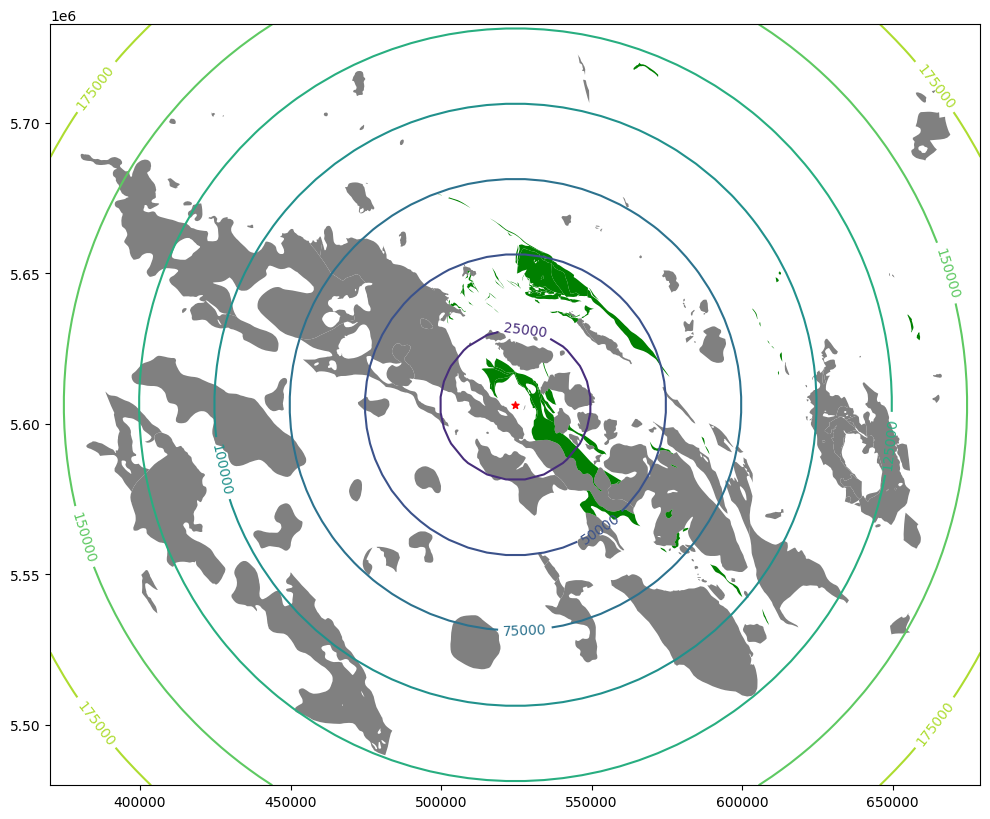

In [28]:
zz = calc_distance(center_x, center_y, xx, yy)
fig, ax = plt.subplots(figsize=(12, 12))
granodiorite_matches.plot(ax=ax, color="gray", zorder=1)
serpentinite_matches.plot(ax=ax, color="green", zorder=2)
ax.scatter([center_x], [center_y], 28, marker='*', color='r')
cp = ax.contour(xx, yy, zz)
clabel = ax.clabel(cp)

Next step is to calculate the distance to the nearest granodiorite and serpentinite from each grid point. To do this, we convert each geometry object of each geological unit into arrays of coordinates.

In [29]:
def get_unit_coords(df: gpd.GeoDataFrame) -> tuple:
    'Retrieve all x, y coordinates of the exterior of every geometry in a geodataframe.'
    xs, ys = [], []
    for geom in df.geometry:
        x, y = geom.exterior.coords.xy
        xs.extend(x)
        ys.extend(y)
    return xs, ys

granodiorite_xs, granodiorite_ys = get_unit_coords(granodiorite_matches)    
serpentinite_xs, serpentinite_ys = get_unit_coords(serpentinite_matches) 

Now we calculate the distance between each gird point and the nearest geological unit. The nearest geological unit is the one where the smallest distance value was found.

In [30]:
def min_distance(xs: list, ys: list, xx: np.array, yy: np.array) -> np.array:
    zs = []
    for x, y in zip(xs, ys):
        z = np.sqrt((xx - x) ** 2 + (yy - y) ** 2)
        zs.append(z)
    return np.array(zs).min(axis=0)
    
granodiorite_zz = min_distance(granodiorite_xs, granodiorite_ys, xx, yy)
serpentinite_zz = min_distance(serpentinite_xs, serpentinite_ys, xx, yy)

Plot the mean distances as a contour plot and compare with the locations of the granodiorite and serpentinite to make sure it makes sense.

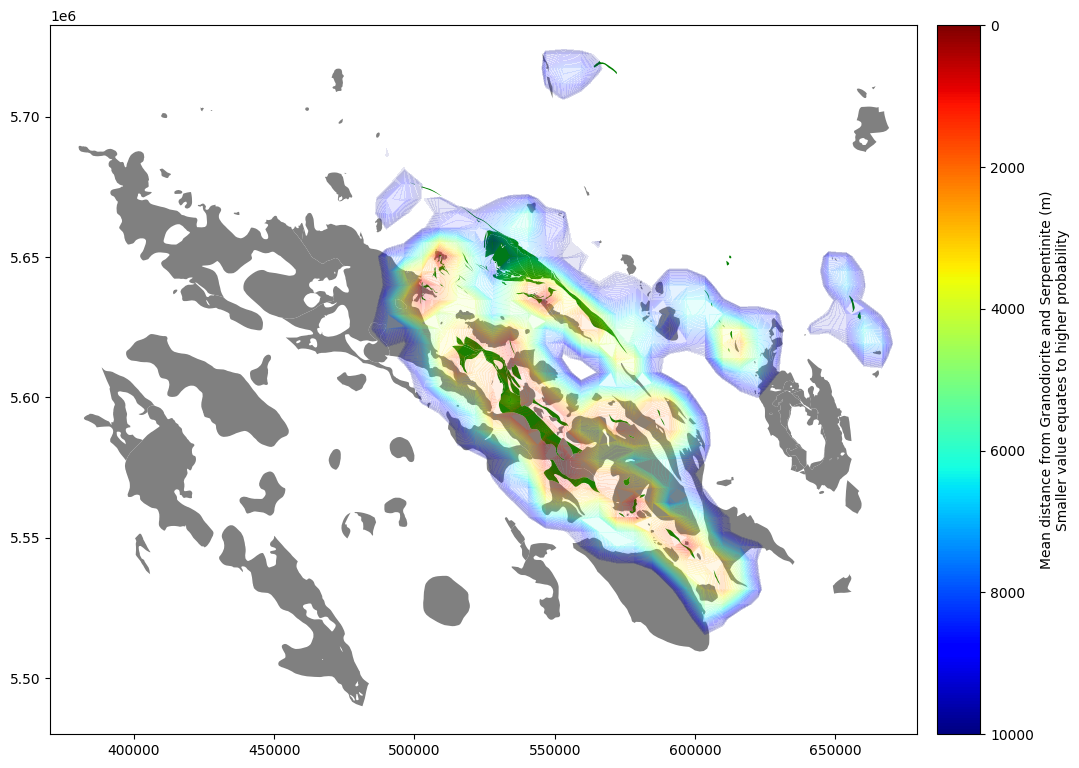

In [36]:
fig, ax = plt.subplots(figsize=(12, 12))
granodiorite_matches.plot(ax=ax, color="gray", zorder=1)
serpentinite_matches.plot(ax=ax, color="green", zorder=2)
mean_distances = (granodiorite_zz + serpentinite_zz) / 2

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cmap = plt.get_cmap('jet').reversed()
norm = mpl.colors.Normalize(vmin=0, vmax=falloff_distance)
cp = ax.contourf(xx, yy, mean_distances, levels=np.linspace(0, falloff_distance, 100), vmin=0, vmax=falloff_distance, alpha=0.1, cmap=cmap, zorder=5)
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, cax=cax, label="Mean distance from Granodiorite and Serpentinite (m)\nSmaller value equates to higher probability")
cbar.ax.invert_yaxis()

As expected, the probability is high near the center of the map. Now add the rest of the geological units.

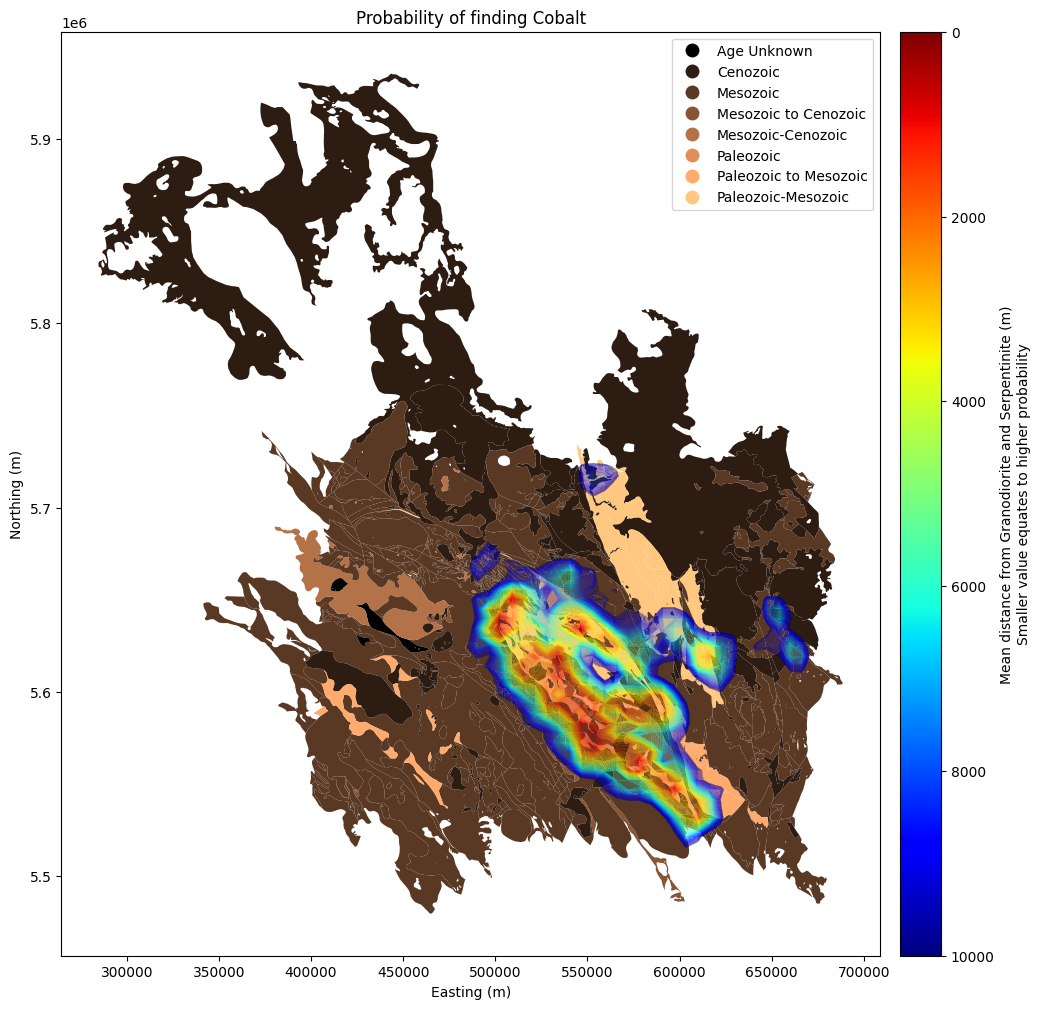

In [37]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_title("Probability of finding Cobalt")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
shp_df.plot(ax=ax, column="era", categorical=True, legend=True, cmap='copper')
mean_distances = (granodiorite_zz + serpentinite_zz) / 2

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cmap = plt.get_cmap('jet').reversed()
norm = mpl.colors.Normalize(vmin=0, vmax=falloff_distance)
cp = ax.contourf(xx, yy, mean_distances, levels=np.linspace(0, falloff_distance, 100), vmin=0, vmax=falloff_distance, alpha=0.2, cmap=cmap, zorder=5)
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, cax=cax, label="Mean distance from Granodiorite and Serpentinite (m)\nSmaller value equates to higher probability")
cbar.ax.invert_yaxis()